In [1]:
cd ..


C:\Users\Nghia\PycharmProjects\ECML\Refactor


In [2]:
from pprint import pprint

import numpy as np
import tensorflow as tf
import time
from collections import Counter

from load_datasets import usps
from metrics import metrics
from models.AE1SVM import AEOneClassSVM

c:\users\nghia\anaconda2\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.set_random_seed(2018)

x_train, y_train, x_test, y_test = usps(random_state=3, anomaly_num=)

counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

Anomalies ratio: 5.0 %


In [4]:
autoencoder_layers = [256, 128, 64]
batch_size = 16

data_input = tf.placeholder(tf.float32, shape=[None, 256])

In [5]:
ae1svm = AEOneClassSVM(data_input, batch_size, 'test', autoencoder_layers[:1], 0.25, 1e3, 3.0, 500,
                       autoencoder_activation='sigmoid',
                       svm_op=tf.train.AdamOptimizer(1e-2))

In [6]:
import matplotlib
import matplotlib.pyplot as plt

normal = x_test[np.where(y_test == 1)]
anomalies = x_test[np.where(y_test == -1)]

SVM train
Epoch: 1 Loss: 0.40881588745117187 AUROC: 0.7305263157894737
Epoch: 2 Loss: 0.21408811950683593 AUROC: 0.8357894736842104
Epoch: 3 Loss: 0.11090203094482422 AUROC: 0.8936842105263157
Epoch: 4 Loss: 0.05649552536010742 AUROC: 0.896842105263158
Epoch: 5 Loss: 0.027986871719360353 AUROC: 0.9505263157894737
Epoch: 6 Loss: 0.013370312690734864 AUROC: 0.9757894736842105
Epoch: 7 Loss: 0.006031342029571533 AUROC: 0.9463157894736842
Epoch: 8 Loss: 0.002467879295349121 AUROC: 0.9726315789473684
Epoch: 9 Loss: 0.0007658889293670655 AUROC: 0.9505263157894737
Epoch: 10 Loss: -3.87418270111084e-06 AUROC: 0.9326315789473685
Epoch: 11 Loss: -0.00033270809054374695 AUROC: 0.8989473684210526
Epoch: 12 Loss: -0.0004707643389701843 AUROC: 0.9473684210526316
Epoch: 13 Loss: -0.0005194150805473328 AUROC: 0.9705263157894737
Epoch: 14 Loss: -0.0005542130470275879 AUROC: 0.9642105263157894
Epoch: 15 Loss: -0.0005721318125724793 AUROC: 0.94
Epoch: 16 Loss: -0.0005645641088485718 AUROC: 0.882105263157

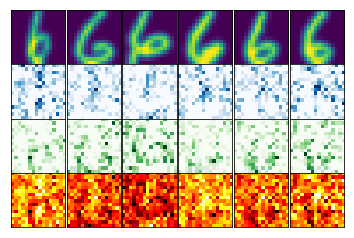

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae1svm.fit_svm(sess, x_train, x_train, y_train, epochs=100)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    out_y = ae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)
    pprint(metrics(y_test, out_y))
    
    gs = matplotlib.gridspec.GridSpec(4, 6)
    gs.update(wspace=0, hspace=0)
    for n in range(6):
        a = anomalies[n]
        g = sess.run(ae1svm.gradient, {data_input: [anomalies[n]]})
        g = np.reshape(g, (256, len(g)))

        splt = plt.subplot(gs[n])
        splt.imshow(np.reshape(anomalies[n], (16, 16)))
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+6])
        splt.imshow(np.maximum(0, np.reshape(g, (16, 16))), cmap='Blues')
        splt.set_xticks([])
        splt.set_yticks([])

        splt = plt.subplot(gs[n+12])
        splt.imshow(np.maximum(0, -np.reshape(g, (16, 16))), cmap='Greens')
        splt.set_xticks([])
        splt.set_yticks([])
        
        splt = plt.subplot(gs[n+18])
        splt.imshow(np.reshape(g, (16, 16)), cmap='hot')
        splt.set_xticks([])
        splt.set_yticks([])  
